### This project attempts to classify SBA Loan's using MLPClassifier and various hyperparameter tuning techniques
Below are the necessary imports I will be using.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sba-loans-case-data-set/SBAcase.11.13.17.csv


### Reading and Cleaning data for Feature Selection
The data set is read into a dataframe using pandas. All non-numeric features are removed. ChgOffDate mostly consistes of NA and BalanceGross is all zeros, so both are removed. The features are placed extracted to X and default dummy variables to y. The total dataset loan default rate is printed below. The feature set is then standarized and normalized.
<br />
TODO: encode and add non-numeric features. Handle NA values. 

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt




df = pd.read_csv("../input/sba-loans-case-data-set/SBAcase.11.13.17.csv")

df = df.select_dtypes(exclude = 'object')
#removes 'ChgOffDate' and 'BalanceGross' features
df = df.loc[:, df.columns != 'ChgOffDate']
df = df.loc[:, df.columns != 'BalanceGross']
df = df.loc[:, df.columns != 'Zip']
#remove remaining NA values
df = df.dropna()
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,0:df.shape[1]-1], df.iloc[:,df.shape[1]-1], test_size = .2)

scaler = StandardScaler()
scaler.fit(x_train)

x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

print('Loan Default percentage in training set: %.1f%%' % (100*np.mean(y_train)))
print('Loan Default percentage in test set: %.1f%%' % (100*np.mean(y_test)))


Loan Default percentage in training set: 32.4%
Loan Default percentage in test set: 33.8%


### Learning Curve f1 score of various training sizes graphed
Seaborn is used to graph the change in f1 over increasing training set sizes. The graph shows a small gap between the validation and training set f1 score, but both continue to converge with more training examples. F1 was used for its combination of both accuracy and percision, but similar results were found using balanced_accuracy and other metrics.

(0.0, 1.0)

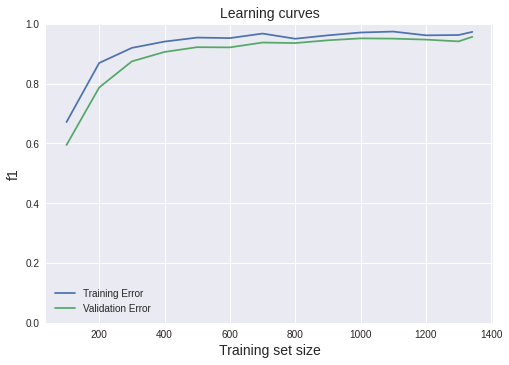

In [3]:
import warnings  
warnings.filterwarnings('ignore')
from sklearn import metrics
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.neural_network import MLPClassifier

# 1342 is max size of training set, with 20% removed for cross validation
bigtrain_sizes = list(range(1,1342))
train_sizes = [1]
for i in bigtrain_sizes:
    if i % 100 == 0:
        train_sizes.append(int(i))
train_sizes.append(1342)


clf = MLPClassifier(batch_size=10, verbose=False, early_stopping=True)
cv = ShuffleSplit(n_splits=10, test_size=0.2)
train_sizes, train_scores, validation_scores = learning_curve(estimator= clf, X = x_train_scaled, y = y_train, train_sizes = train_sizes, cv = cv, scoring = 'f1', verbose = 0)
train_scores_mean = train_scores.mean(axis =1)
validation_scores_mean = validation_scores.mean(axis = 1)


plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = "Training Error")
plt.plot(train_sizes, validation_scores_mean, label = "Validation Error")
plt.ylabel('f1', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title("Learning curves", fontsize = 14)
plt.legend()
plt.ylim(0,1)

### Validation Curve used for simple hyperparameter tuning
I experimented with various activation functions, learning rates, hidden layer sizes, and solver functions to try and find ideal hyperparameters. 

[0.97971472 0.94655784 0.9405721  0.9412129 ]


(0.5, 1.0)

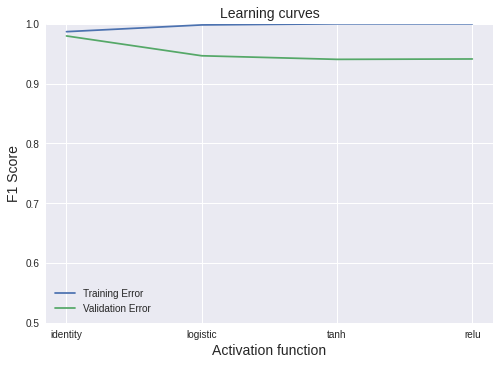

In [4]:
from sklearn.model_selection import validation_curve

x_train_, x_val, y_train_, y_val = train_test_split(x_train_scaled, y_train, test_size = .2)
# print(x_train_.shape)
# print(x_train.shape)

# hidden_layer_sizes params
bighidden_sizes = list(range(300,401))
hidden_param_range = [300]
for i in bighidden_sizes:
    if i % 10 == 0:
        hidden_param_range.append(int(i))
param_range_len = np.arange(len(hidden_param_range))

# solver params
solver_param_range = ('lbfgs', 'sgd', 'adam')

# activation params
act_param_range = ('identity', 'logistic', 'tanh', 'relu')

# learning_curve params
learn_param_range = ('constant', 'invscaling', 'adaptive')

param_range = act_param_range

clf = MLPClassifier(batch_size=10, solver = 'lbfgs', hidden_layer_sizes = 300, verbose=False, early_stopping=True)
cv = ShuffleSplit(n_splits=10, test_size=0.2)
train_scores, validation_scores = validation_curve(estimator= clf, X = x_train_, y = y_train_, param_name = 'activation', param_range = param_range, cv = cv, scoring = 'f1', verbose = 0)
train_scores_mean = train_scores.mean(axis =1)
validation_scores_mean = validation_scores.mean(axis = 1)
# print(pd.Series(train_scores_mean, index = train_sizes))
# print(pd.Series(validation_scores_mean, index = train_sizes))
print(validation_scores_mean)

plt.style.use('seaborn')
plt.plot(param_range, train_scores_mean, label = "Training Error")
plt.plot(param_range, validation_scores_mean, label = "Validation Error")
plt.ylabel('F1 Score', fontsize = 14)
plt.xlabel('Activation function', fontsize = 14)
plt.title("Learning curves", fontsize = 14)
plt.legend()
plt.ylim(.5,1)

### MLPClassifier model with ideal parameters found using validation curves
The identity activation function, invscaling learning rate, and lbfgs solver were found to improve accuracy the most using various validation curves. Hidden layers sizes between 1 and 500 were also experimented with, but only using one hidden layer. I intend of incorporate tuning on multiple hidden layers in the future.

Dummy model accuracy: 66.190%
Training set k-fold cross validation mean accuracy: 98.327%
Validation set accuracy: 98.512%
Test set accuracy: 98.333%
AUC: 99.858%
Log loss: 0.051
F1 Score: 0.975


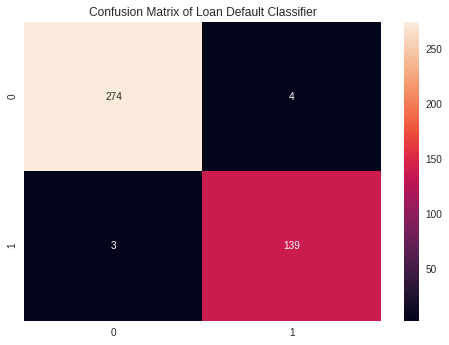

In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, log_loss, f1_score
import seaborn as sns

x_train_, x_val, y_train_, y_val = train_test_split(x_train_scaled, y_train, test_size = .2)

#dummy model accuracy (baseline)
dummy_model = DummyClassifier(strategy = "most_frequent")
dummy_model.fit(x_train_scaled,y_train)
dummy_acc = dummy_model.score(x_test_scaled,y_test)*100
dumb_pred = dummy_model.predict(x_test_scaled)
print('Dummy model accuracy: %.3f%%' % dummy_acc)

def getModel():
    model = MLPClassifier(batch_size=10, solver = 'lbfgs', learning_rate = 'invscaling', activation = 'identity', hidden_layer_sizes = 300, verbose=False, early_stopping=True)
    model.fit(x_train_,y_train_)
    return model
    
model = getModel()

# 10 fold cross validation score
cv = ShuffleSplit(n_splits=10, test_size=0.2)
results = cross_val_score(model, x_train_, y_train_, cv=cv)
print('Training set k-fold cross validation mean accuracy: %.3f%%' % (100*np.mean(results)))

#basic predict - validation set
y_pred1 = model.predict(x_val)
pred_accuracy_percentage1 = 100 * accuracy_score(y_val,y_pred1)
print('Validation set accuracy: %.3f%%' % pred_accuracy_percentage1)

#basic predict - test set
y_pred = model.predict(x_test_scaled)
pred_accuracy_percentage = 100 * accuracy_score(y_test,y_pred)
print('Test set accuracy: %.3f%%' % pred_accuracy_percentage)

#ROC AUC metric
# pred_auc = model.predict(x_test)
pred_auc = model.predict_proba(x_test_scaled)[:,1]
acc = roc_auc_score(y_test, pred_auc)
print('AUC: %.3f%%' % (100*acc))

#log loss metric
lloss = log_loss(y_test,pred_auc, normalize = True)
print('Log loss: %.3f' % lloss)

#f1_score
f1 = f1_score(y_test,y_pred)
print('F1 Score: %.3f' % f1)

#Confusion Matrix
plt.figure()
ax = plt.axes()
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot = True, fmt = 'd', ax = ax)
ax.set_title('Confusion Matrix of Loan Default Classifier')
plt.show()



